## 1) Import libraries

In [1]:
import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages")

import numpy as np
import pandas as pd

import re

import matplotlib.pyplot as plt

from functions import *

import pickle

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

from scipy import sparse

import math

In [2]:
def splitAtUpperCase(s):
    for i in range(len(s)-1)[::-1]:
        if s[i].isupper() and s[i+1].islower():
            s = s[:i]+' '+s[i:]
        if s[i].isupper() and s[i-1].islower():
            s = s[:i]+' '+s[i:]
        if s[i].isdigit() and s[i+1].isalpha():
            s = s[:i+1]+' '+s[i+1:]
        if s[i].isdigit() and s[i-1].isalpha():
            s = s[:i]+' '+s[i:]
        if s[i].isalpha() and s[i+1].isdigit():
            s = s[:i+1]+' '+s[i+1:]
        if s[i].isalpha() and s[i-1].isdigit():
            s = s[:i]+' '+s[i:]
    return s.split()

## 2) Import data

In [3]:
data = pd.read_csv("dataset_whole.csv", index_col = 0)

In [4]:
len(data["connRef"].unique())

37

In [5]:
data = pd.read_csv("dataset_whole.csv", index_col = 0)
data = data.drop(["inverted"],axis=1)
data_serviceType = pd.read_csv("dataset_whole_1.csv", index_col = 0)[["connRef","serviceType"]]

In [6]:
data.shape, data_serviceType.shape

((42292, 47), (42292, 2))

In [7]:
discard_sites = ['Capita - Sky Park','Capita - Bury Dummers Lane','Capita - Hartshead House','0','Node Red data']
for site in discard_sites:
    data = data[data["connRef"] != site ]
    data_serviceType = data_serviceType[data_serviceType["connRef"] != site]

In [8]:
data.shape, data_serviceType.shape

((33906, 47), (33906, 2))

In [9]:
data["connRef"].unique(), data_serviceType["connRef"].unique()

(array(['LBG 50014000 Brindley Place', 'LBG 50450189 Brotherton House',
        'LBG 50450520 London Holbrook House', 'LBG 50490000 Twickenham',
        'LBG 50884200 Red Lion Court', 'LBG 50960185 Doncaster Halifax',
        'LBG 50960279 New Bridge Street Newcastle',
        'LBG 50960345 The Bridges Shopping Centre',
        'LBG 50960417 Carlisle', 'LBG 50960422 St Werburgh Row Chester',
        'LBG 50960533 St Helens', 'LBG 50960603 Bury St Edmunds Cornhill',
        'LBG 50960618 Colchester Head Street',
        'LBG 50961735 Westbank Leeds', 'LBG 50963912 Heathside Park',
        'LBG 50963969 Lisbon House', 'Vodafone - Berkeley Square',
        'MOJ Westminster Magistrates Court', 'MOJ Winchester Law Courts',
        'Rolls Royce Annesley', 'Rolls Royce Ansty',
        'Rolls Royce Barnoldswick', 'Rolls Royce Derby EOS Rotatives',
        'Rolls Royce Heathrow Service Centre', 'Rolls Royce Inchinnan',
        'Rolls-Royce - Jubilee House Derby', 'Rolls Royce Rotherham',
      

In [10]:
building_test = data["connRef"].unique()[1]

In [11]:
building_test

'LBG 50450189 Brotherton House'

In [12]:
test = data[data["connRef"]==building_test]
train = data[data["connRef"]!=building_test]

In [13]:
serviceType_test = data_serviceType[data_serviceType["connRef"]==building_test][["serviceType"]]
serviceType_train = data_serviceType[data_serviceType["connRef"]!=building_test][["serviceType"]]

In [14]:
X_train = train[["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"]]
X_test = test[["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"]]

y_train = train.drop(["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"], axis = 1)
y_test = test.drop(["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"], axis = 1)

In [15]:
data.head()

navName                      connRef contractRef  \
0  5thFlr DX3 Cash Office Enable  LBG 50014000 Brindley Place         LBG   
1   DX Unit 3 5th Post Room Temp  LBG 50014000 Brindley Place         LBG   
2      6thFlr DX1 Kitchen Enable  LBG 50014000 Brindley Place         LBG   
3    DX Unit 1 Kitchen Room Temp  LBG 50014000 Brindley Place         LBG   
4      6thFlr DX2 Meeting Enable  LBG 50014000 Brindley Place         LBG   

  controllerReference pointReference    kind unit  hisInterval  hisSize  air  \
0               L1O11        D11(Sv)    Bool    0        300.0  58820.0    0   
1               L1O11         S10(V)  Number   °C        300.0  58822.0    1   
2               L1O11         D9(Sv)    Bool    0        300.0  58823.0    0   
3               L1O11          S8(V)  Number   °C        300.0  58816.0    1   
4               L1O11        D10(Sv)    Bool    0        300.0  58820.0    0   

   ...  recirc  return  run  sensor  sp  speed  temp  valve  water  zone  
0  ...       0       0    0       0   0      0     0      0      0     0  
1  ...       0       0    0       1   0      0     1      0      0     0  
2  ...       0       0    0       0   0      0     0      0      0     0  
3  ...       0       0    0       1   0      0     1      0      0     0  
4  ...       0       0    0       0   0      0     0      0      0     0  

[5 rows x 47 columns]

## 3) Parsing Data

### Uncomment when not selecting a specific building

In [16]:
#from sklearn.model_selection import train_test_split

In [17]:
#X = data[["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"]]
#y = data.drop(["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"], axis = 1)

In [18]:
#X_train, X_test, y_train, y_test, serviceType_train, serviceType_test = train_test_split(X.reset_index(drop=True), y.reset_index(drop=True), data_serviceType, test_size=0.1, random_state=42)

--------------------------------------------------------------------------------------------------

In [19]:
y_train_1 = y_train[["cmd", "sp", "sensor"]]
y_test_1 = y_test[["cmd", "sp", "sensor"]]

header = y_train.columns.tolist()
header.remove("cmd")
header.remove("sp")
header.remove("sensor")
y_train_2 = y_train[header]
y_test_2 = y_test[header]

### 3.1) Labels (navName)

In [20]:
labels_list_train = X_train[["navName"]].values.tolist()
labels_list_test = X_test[["navName"]].values.tolist()

In [21]:
# importing modules 
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
   
ps = PorterStemmer() 

In [22]:
dictionary = pd.read_csv("dict.csv",header=None).set_index(0).T.to_dict("list")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """Entry point for launching an IPython kernel.


In [23]:
def labels_processing(labels_list, dictionary):
    labels = []
    for label in labels_list:
        
        #label = splitAtUpperCase(label[0])

        #label = label[0].lower()
        #print(label)
        #label = re.sub(r"[0-9]","",label)
        label = re.sub("[.]"," ",label[0])
        #label = label.lower().split()
        label = splitAtUpperCase(label)
        for i in range(0,len(label)):
            label[i] = label[i].lower()
            if label[i] in dictionary:
                label[i] = dictionary[label[i]][0]
        #label = " ".join(label)
        labels += [label] 
        
    return labels

In [24]:
labels_list_train

[['5thFlr DX3 Cash Office Enable'],
 ['DX Unit 3 5th Post Room Temp'],
 ['6thFlr DX1 Kitchen Enable'],
 ['DX Unit 1 Kitchen Room Temp'],
 ['6thFlr DX2 Meeting Enable'],
 ['DX Unit 2 6th Meeting Room Tmp'],
 ['Chiller 1 Enable'],
 ['Chiller No.1 Fault'],
 ['Chiller No.1 Run'],
 ['Chiller 2 Enable'],
 ['Chiller No.2 Fault'],
 ['Chiller No.2 Run'],
 ['Chiller Core Hrs'],
 ['Chiller Flow Temp'],
 ['Chiller Return Temp'],
 ['ChW Calculated Setpoint'],
 ['CHW Pump 1 Enable'],
 ['CHW Pump1 inv Fault'],
 ['CHW Pump1 Inverter OP'],
 ['CWSPriPump1Fail'],
 ['CWSPump1 Speed Setpt'],
 ['CHW Pump 2 Enable'],
 ['CHW Pump2 Flow'],
 ['CHW Pump2 inv Fault'],
 ['CHW Pump2 Inverter OP'],
 ['CWSPriPump2Fail'],
 ['CWSPump2 Speed Setpt'],
 ['Chilllers Eco Mode Setpoint'],
 ['CHW Pump1 Flow'],
 ['CHW PUnit Fault'],
 ['Cooling ECO Mode'],
 ['CWS Booster Fault'],
 ['CWS Flow Temp Alarm'],
 ['CWS Tank Temp'],
 ['DX No 1 & 2  Enable'],
 ['DX01 AC Unit Fault'],
 ['DX02 AC Unit Fault'],
 ['DX No 3 & 4  Enable'],
 [

In [25]:
labels_train = labels_processing(labels_list_train, dictionary)
labels_test = labels_processing(labels_list_test, dictionary)

In [26]:
labels = []
for w in labels_train:
    labels += [[ps.stem(word) for word in w]]
labels_train = labels
labels = []
for w in labels_test:
    labels += [[ps.stem(word) for word in w]]
labels_test = labels

In [27]:
labels_train = [" ".join(i) for i in labels_train]
labels_test = [" ".join(i) for i in labels_test]

In [28]:
labels_train

['5 th floor dx 3 cash offic enabl',
 'dx unit 3 5 th post room temp',
 '6 th floor dx 1 kitchen enabl',
 'dx unit 1 kitchen room temp',
 '6 th floor dx 2 meet enabl',
 'dx unit 2 6 th meet room tmp',
 'chiller 1 enabl',
 'chiller no 1 fault',
 'chiller no 1 run',
 'chiller 2 enabl',
 'chiller no 2 fault',
 'chiller no 2 run',
 'chiller core hr',
 'chiller flow temp',
 'chiller return temp',
 'ch w calcul sp',
 'chw pump 1 enabl',
 'chw pump 1 inv fault',
 'chw pump 1 invert op',
 'cw primari pump 1 fail',
 'cw pump 1 speed setpt',
 'chw pump 2 enabl',
 'chw pump 2 flow',
 'chw pump 2 inv fault',
 'chw pump 2 invert op',
 'cw primari pump 2 fail',
 'cw pump 2 speed setpt',
 'chilller eco mode sp',
 'chw pump 1 flow',
 'chw p unit fault',
 'cool eco mode',
 'cw booster fault',
 'cw flow temp alarm',
 'cw tank temp',
 'dx no 1 & 2 enabl',
 'dx 01 ac unit fault',
 'dx 02 ac unit fault',
 'dx no 3 & 4 enabl',
 'dx 03 ac unit fault',
 'dx 04 ac unit fault',
 'ground floor dx 2 secur enabl',

In [29]:
labels_test

['chiller 1 enabl',
 'chiller a fault',
 'chiller a isol valv',
 'chiller a isol valv or',
 'chiller 2 enabl',
 'chiller b fault',
 'chiller b isol valv',
 'chiller pump flow',
 'chiller b isol valv or',
 'chiller pump 1 enabl',
 'chiller pump 1 fault',
 'chiller pump 2 enabl',
 'chiller pump 2 fault',
 'pump a run',
 'pump a trip',
 'pump b run',
 'pump b trip',
 'flow sp',
 'flow temp',
 'return temp',
 'common alarm',
 'control valv a',
 'control valv b',
 'fire alarm',
 'flow sw a',
 'flow sw b',
 'flow temp',
 'isol valv a',
 'isol valv b',
 'return temp',
 'under floor leakag',
 'chiller a flow temp',
 'chiller a return temp',
 'chiller b flow temp',
 'chiller b return temp',
 'chiller return temp',
 'chiller',
 'h t c w flow 1 flow',
 'ht c w flow 2 return',
 'phe no 1',
 'phe no 2',
 '1 st stage frost',
 'amen load shed',
 'chiller 1 compressor 1',
 'chiller 1 compressor 2',
 'chiller 1 compressor 3',
 'chiller 1 compressor 4',
 'chiller 2 compressor 1',
 'chiller 2 compressor 

In [30]:
from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
count_vect = CountVectorizer(ngram_range=(1,2))
count_vect.fit(labels_train)
count_vect.fit(labels_test)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [31]:
labels_sparse_train = count_vect.transform(labels_train)
labels_sparse_test = count_vect.transform(labels_test)

In [32]:
# Helper function
#def print_topics(model, count_vectorizer, n_top_words):
 #   words = count_vectorizer.get_feature_names()
  #  for topic_idx, topic in enumerate(model.components_):
   #     print("\nTopic #%d:" % topic_idx)
    #    print(" ".join([words[i]
     #                   for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [33]:
# Load the LDA model from sk-learn
#from sklearn.decomposition import LatentDirichletAllocation as LDA
# Tweak the two parameters below
#number_topics = 20
#number_words = 10
# Create and fit the LDA model
#lda = LDA(n_components=number_topics)
#lda.fit(labels_sparse_train)

In [34]:
#labels_sparse_train.shape

In [35]:
#lda_categories_train = lda.transform(labels_sparse_train)
#lda_categories_test = lda.transform(labels_sparse_test)

In [36]:
#print_topics(lda, count_vect, number_words)

In [37]:
#lda_sparse_train = sparse.csr_matrix(lda_categories_train)
#lda_sparse_test = sparse.csr_matrix(lda_categories_test)

### 3.2) Lan/outstation

In [38]:
lanOut = [re.sub("\D"," ",field[0]).split() for field in data[["controllerReference"]].values.tolist()]

lanOut_train = [re.sub("\D"," ",field[0]).split() for field in X_train[["controllerReference"]].values.tolist()]
lanOut_test = [re.sub("\D"," ",field[0]).split() for field in X_test[["controllerReference"]].values.tolist()]

In [39]:
#transform in "int" type the first vector member
for i in range(0, len(lanOut)):
    lanOut[i][0]=int(lanOut[i][0])
for i in range(0, len(lanOut_train)):
    lanOut_train[i][0]=int(lanOut_train[i][0])
for i in range(0, len(lanOut_test)):
    lanOut_test[i][0]=int(lanOut_test[i][0])

In [40]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(lanOut)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [41]:
lanOut_train = enc.transform(lanOut_train)
lanOut_test = enc.transform(lanOut_test)

In [42]:
lanOut_sparse_train = sparse.csr_matrix(lanOut_train)
lanOut_sparse_test = sparse.csr_matrix(lanOut_test)

In [43]:
lanOut_sparse_train.shape, lanOut_sparse_test.shape

((33404, 136), (502, 136))

### 3.3) Controller Ref

In [44]:
controllerRef = data[["pointReference"]].values.tolist()

controllerRef_train = X_train[["pointReference"]].values.tolist()
controllerRef_test = X_test[["pointReference"]].values.tolist()

In [45]:
#Substitute parenthesis by blank space
conRef_process1 = [re.sub("[()]"," ",controllerRef[i][0]) for i in range(0,len(controllerRef))]

conRef_process1_train = [re.sub("[()]"," ",controllerRef_train[i][0]) for i in range(0,len(controllerRef_train))]
conRef_process1_test = [re.sub("[()]"," ",controllerRef_test[i][0]) for i in range(0,len(controllerRef_test))]

In [46]:
third_field = [conRef_process1[i].split()[1] for i in range(0,len(conRef_process1))]

third_field_train = [conRef_process1_train[i].split()[1] for i in range(0,len(conRef_process1_train))]
third_field_test = [conRef_process1_test[i].split()[1] for i in range(0,len(conRef_process1_test))]

In [47]:
first_field = [conRef_process1[i][0] for i in range(0,len(conRef_process1))]

first_field_train = [conRef_process1_train[i][0] for i in range(0,len(conRef_process1_train))]
first_field_test = [conRef_process1_test[i][0] for i in range(0,len(conRef_process1_test))]

In [48]:
second_field = [conRef_process1[i].split()[0][1:] for i in range(0,len(conRef_process1))]

second_field_train = [conRef_process1_train[i].split()[0][1:] for i in range(0,len(conRef_process1_train))]
second_field_test = [conRef_process1_test[i].split()[0][1:] for i in range(0,len(conRef_process1_test))]

In [49]:
conRef = [[first_field[i],second_field[i],third_field[i]] for i in range(0, len(first_field))]

conRef_train = [[first_field_train[i],second_field_train[i],third_field_train[i]] for i in range(0, len(first_field_train))]
conRef_test = [[first_field_test[i],second_field_test[i],third_field_test[i]] for i in range(0, len(first_field_test))]

In [50]:
enc_ref = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_ref.fit(conRef)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [51]:
conRef_train = enc_ref.transform(conRef_train)
conRef_test = enc_ref.transform(conRef_test)

In [52]:
conRef_sparse_train = sparse.csr_matrix(conRef_train)
conRef_sparse_test = sparse.csr_matrix(conRef_test)

In [53]:
conRef_sparse_train.shape, conRef_sparse_test.shape

((33404, 237), (502, 237))

### 3.4) Kind

In [54]:
kind = data[["kind"]].values.tolist()

kind_train = X_train[["kind"]].values.tolist()
kind_test = X_test[["kind"]].values.tolist()

enc_kind = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_kind.fit(kind)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [55]:
kind_train = enc_kind.transform(kind_train)
kind_test = enc_kind.transform(kind_test)

In [56]:
kind_sparse_train = sparse.csr_matrix(kind_train)
kind_sparse_test = sparse.csr_matrix(kind_test)

### 3.5) Units

In [58]:
units = data[["unit"]].values.tolist()

units_train = X_train[["unit"]].values.tolist()
units_test = X_test[["unit"]].values.tolist()

enc_units = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_units.fit(units)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [59]:
units_train = enc_units.transform(units_train)
units_test = enc_units.transform(units_test)

In [60]:
units_sparse_train = sparse.csr_matrix(units_train)
units_sparse_test = sparse.csr_matrix(units_test)

## 4) Concatenate all

In [61]:
sX_train = sparse.hstack([labels_sparse_train,conRef_sparse_train,lanOut_sparse_train,kind_sparse_train,units_sparse_train])
sX_test = sparse.hstack([labels_sparse_test,conRef_sparse_test,lanOut_sparse_test,kind_sparse_test,units_sparse_test])

In [62]:
sX_train.shape, sX_test.shape

((33404, 936), (502, 936))

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [64]:
from xgboost import XGBClassifier

In [65]:
y_train_1_XGBoost = np.argmax(y_train_1.values, axis=1)
y_test_1_XGBoost = np.argmax(y_test_1.values, axis=1)

In [66]:
%%time

# initialize label powerset multi-label classifier
classifier_1 = XGBClassifier()
#classifier_1 = RandomForestClassifier(n_estimators=100)

# train
classifier_1.fit(sX_train,y_train_1_XGBoost)

# predict
predictions = classifier_1.predict(sX_test)
#predictions_val = classifier.predict(data_val)

# accuracy
print("Accuracy = ",accuracy_score(y_test_1_XGBoost,predictions))
print("\n")

Accuracy =  0.9960159362549801


CPU times: user 4.02 s, sys: 11.4 ms, total: 4.03 s
Wall time: 4.04 s


In [67]:
predictions.shape

(502,)

In [68]:
probabilities_1 = classifier_1.predict_proba(sX_test)

In [69]:
threshold = 0.80

In [70]:
predictions.shape, sX_test.shape, y_train_2.shape, y_train_1.shape

((502,), (502, 936), (33404, 35), (33404, 3))

In [71]:
predictions = np.reshape(predictions,(-1,1))

In [72]:
predictions.shape

(502, 1)

In [73]:
enc = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(predictions)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [74]:
spredictions = enc.transform(predictions)

In [75]:
spredictions.toarray().shape, y_train_1.shape

((502, 3), (33404, 3))

In [76]:
results_1 = spredictions.toarray().copy()
#results_1 = np.reshape(results_1,(-1,1))

In [77]:
spredictions

<502x3 sparse matrix of type '<class 'numpy.float64'>'
	with 502 stored elements in Compressed Sparse Row format>

In [78]:
results_1.shape

(502, 3)

In [79]:
sX_test.shape, spredictions.shape

((502, 936), (502, 3))

In [80]:
y_train_1 = sparse.csr_matrix(y_train_1.values) 

In [81]:
y_train_1.shape

(33404, 3)

In [82]:
#Preparing new test data (test_1 + predictions)
#spredictions = sparse.csr_matrix(predictions) 
sX_test_2 = sparse.hstack([sX_test,spredictions])

#Preparing new training data (train_1 + y_train_1)
sX_train_2 = sparse.hstack([sX_train,y_train_1])

In [83]:
sX_test_2.shape, sX_train_2.shape

((502, 939), (33404, 939))

In [84]:
results_2 = np.empty(sX_test_2.shape[0])
results_2 = np.reshape(results_2, (-1,1))

probabilities_2 = np.empty(sX_test_2.shape[0])
probabilities_2 = np.reshape(probabilities_2, (-1,1))

In [85]:
for category in list(y_train_2):
    
    classifier_2 = XGBClassifier()
    classifier_2.fit(sX_train_2, y_train_2[[category]])
    
    # predict
    predictions_2 = classifier_2.predict(sX_test_2)
    probs_2 = classifier_2.predict_proba(sX_test_2)
    
    predictions_train_2 = classifier_2.predict(sX_train_2)
    #predictions_val = classifier.predict(data_val)
    
    predictions_2 = np.reshape(predictions_2, (-1,1))
    results_2 = np.concatenate((results_2, predictions_2), axis=1)
    
    #probs_2 = np.reshape(probs_2, (-1,1))
    
    probs_2 = probs_2[:,[1]]
    print(probs_2.shape)
    
    probabilities_2 = np.concatenate((probabilities_2, probs_2), axis=1)
    
    # accuracy
    print(category)
    print(probabilities_2.shape)
    print("Training Accuracy = ",accuracy_score(y_train_2[[category]],predictions_train_2))
    print("Test Accuracy = ",accuracy_score(y_test_2[[category]],predictions_2))
    print("\n")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(502, 1)
air
(502, 2)
Training Accuracy =  0.9562627230271824
Test Accuracy =  0.900398406374502


(502, 1)
alarm
(502, 3)
Training Accuracy =  0.9733564842533828
Test Accuracy =  0.9123505976095617


(502, 1)
chilled
(502, 4)
Training Accuracy =  0.9969464734762304
Test Accuracy =  0.9681274900398407


(502, 1)
co2
(502, 5)
Training Accuracy =  0.9996108250508922
Test Accuracy =  1.0


(502, 1)
cool
(502, 6)
Training Accuracy =  0.9973356484253383
Test Accuracy =  0.9741035856573705


(502, 1)
damper
(502, 7)
Training Accuracy =  0.9994012693090648
Test Accuracy =  0.9920318725099602


(502, 1)
discharge
(502, 8)
Training Accuracy =  0.9876960843012813
Test Accuracy =  0.9561752988047809


(502, 1)
enable
(502, 9)
Training Accuracy =  0.9997904442581727
Test Accuracy =  1.0


(502, 1)
energy
(502, 10)
Training Accuracy =  1.0
Test Accuracy =  1.0


(502, 1)
entering
(502, 11)
Training Accuracy =  0.9991019039635972
Test Accuracy =  0.9940239043824701


(502, 1)
extract
(502, 12)
Train

In [86]:
results_2 = np.delete(results_2, 0, 1)
probabilities_2 = np.delete(probabilities_2, 0, 1)

# Service type

In [87]:
#serviceType = data_serviceType["serviceType"].str.lower().values.tolist()

serviceType_train = serviceType_train.applymap(lambda s:s.lower() if type(s) == str else s)
serviceType_test = serviceType_test.applymap(lambda s:s.lower() if type(s) == str else s)

serviceType_train = serviceType_train.values
serviceType_test = serviceType_test.values

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [89]:
#Preparing new test data (test_1 + predictions)
#spredictions = sparse.csr_matrix(predictions_2) 
spredictions = sparse.csr_matrix(results_2) 
sX_test_3 = sparse.hstack([sX_test_2,spredictions])
#sX_test_3 = sX_test

#Preparing new training data (train_1 + y_train_1)
sX_train_3 = sparse.hstack([sX_train_2,y_train_2])
#sX_train_3 = sX_train

In [90]:
%%time

# initialize label powerset multi-label classifier
classifier_3 = XGBClassifier()

# train
classifier_3.fit(sX_train_3, serviceType_train)

# predict
predictions_train = classifier_3.predict(sX_train_3)
results_3 = classifier_3.predict(sX_test_3)
#predictions_val = classifier_1.predict(data_val)

# accuracy
print("Train Accuracy = ",accuracy_score(serviceType_train,predictions_train))
print("Test Accuracy = ",accuracy_score(serviceType_test,results_3))
print("\n")

Train Accuracy =  0.8552269189318644
Test Accuracy =  0.20119521912350596


CPU times: user 13.7 s, sys: 49 ms, total: 13.8 s
Wall time: 13.8 s


In [91]:
results_3 = np.reshape(results_3,(-1,1))

In [92]:
probabilities_3 = classifier_3.predict_proba(sX_test_3)
probabilities_3.shape

(502, 8)

#### Total prediction accuracy

In [93]:
results_1.shape, results_2.shape, results_3.shape

((502, 3), (502, 35), (502, 1))

In [94]:
#All results concatenate
results = np.concatenate((results_1,results_2,results_3),axis=1)

In [95]:
pred = pd.DataFrame(results, columns = ["cmd", "sp", "sensor"] + list(y_train_2) + ["serviceType"])

In [96]:
serviceType_test = pd.DataFrame(serviceType_test,columns=["serviceType"])

In [97]:
#BLUNDER. I think that this can be fixed at the beginning
test = pd.concat([test.reset_index(drop=True), serviceType_test.reset_index(drop=True)],axis=1)

In [98]:
test = test[list(pred)]
pred = pred.iloc[:,:-1].astype(int)
test_tags = [list(filter(None, test.iloc[i,:-1].values * test.iloc[:,:-1].columns.values)) for i in range(0,len(test))]
pred_tags = [list(filter(None, pred.iloc[i].values * pred.columns.values)) for i in range(0,len(pred))]

In [99]:
acc_list_serviceType = [test.iloc[:,-1].values.tolist()[i] == results_3.T.tolist()[0][i] for i in range(0,len(test))]
acc_list_pointTags = [test.iloc[i,:-1].values.tolist() == pred.iloc[i].values.tolist() for i in range(0,len(test))]

In [100]:
#Maybe the accuracy of all together is a bit pointless?
acc_list = [acc_list_serviceType[i] == True and acc_list_pointTags[i] == True for i in range(0,len(test))]

In [101]:
accuracy_total = (len(acc_list) - acc_list.count(False))/len(acc_list)*100

In [102]:
serviceType_acc_total = (len(acc_list_serviceType) - acc_list_serviceType.count(False))/len(acc_list_serviceType)*100
pointTags_acc_total = (len(acc_list_pointTags) - acc_list_pointTags.count(False))/len(acc_list_pointTags)*100

In [103]:
print("The total accuracy for pointTags is: %.2f" % round(pointTags_acc_total,2),"%")
print("The total accuracy for serviceType is: %.2f" % round(serviceType_acc_total,2),"%")

The total accuracy for pointTags is: 61.95 %
The total accuracy for serviceType is: 20.12 %


#### Probabilities and prediction confidence

In [103]:
#probabilities = np.concatenate((probabilities_1, probabilities_2, probabilities_3), axis=1)

In [104]:
probabilities_pointTags = np.concatenate((probabilities_1, probabilities_2), axis=1)
probabilities_serviceType = probabilities_3.copy()

In [105]:
# Calculation of confidence 2 x abs(probabilities - 0.5)
confidence_pointTags = 2*abs(probabilities_pointTags-0.5)
confidence_serviceType = 2*abs(probabilities_serviceType-0.5)

In [106]:
threshold = 0.6

condlist_pointTags = [confidence_pointTags < threshold]
condlist_serviceType = [confidence_serviceType < threshold]

choicelist = [1]

non_confident_predictions_pointTags = np.select(condlist_pointTags, choicelist)
non_confident_predictions_serviceType = np.select(condlist_serviceType, choicelist)


In [107]:
revise = [list(filter(None, non_confident_predictions_pointTags[i] * pred.columns.values)) for i in range(0,len(pred))]
revision_needed = [i != [] for i in revise]


In [108]:
non_confident_predictions_serviceType = np.argmax(non_confident_predictions_serviceType, axis=1)

In [109]:
non_confident_predictions_serviceType = np.nan_to_num(non_confident_predictions_serviceType/non_confident_predictions_serviceType,0).astype(int)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [110]:
revise_serviceType = [msg == 1 for msg in non_confident_predictions_serviceType]

In [111]:
revise_serviceType = [list(filter(None, non_confident_predictions_serviceType[i] * results_3.T[0])) for i in range(0,len(pred))]
revision_needed_serviceType = [i == [] for i in revise_serviceType]


In [112]:
revision_needed_perc_pointTags = (len(revision_needed) - revision_needed.count(True))/len(revision_needed)*100
revision_needed_perc_serviceType = (len(revision_needed_serviceType) - revision_needed_serviceType.count(True))/len(revision_needed_serviceType)*100
revision_needed_perc_pointTags, revision_needed_perc_serviceType


(45.81673306772908, 80.0796812749004)

#### Table of results

In [113]:
dict_results = {"Label Name":X_test["navName"].values.tolist(),"L/O":X_test["controllerReference"].values.tolist(),"Ref":X_test["pointReference"].values.tolist(),"Kind":X_test["kind"].values.tolist(),"Unit":X_test["unit"].values.tolist(),"Actual Tags":test_tags,"Predicted Tags":pred_tags,"Success":acc_list,"To Revise":revise,"Revision Needed pointTags":revision_needed, "serviceType":serviceType_test.values.tolist(), "Predicted serviceType":results_3.tolist(), "Success serviceType":acc_list_serviceType, "Revision Needed serviceType":revision_needed_serviceType}

In [114]:
results = pd.DataFrame(dict_results).set_index(["Label Name"])
results

L/O      Ref    Kind Unit  \
Label Name                                                
Chiller 1 Enable           L65O65   D3(Sv)    Bool    0   
Chiller A Fault            L65O65    I4(S)    Bool    0   
Chiller A Isolation Valve  L65O65   D7(Sv)    Bool    0   
Chiller A Isol Valve OR    L65O65   I11(S)    Bool    0   
Chiller 2 Enable           L65O65   D4(Sv)    Bool    0   
Chiller B Fault            L65O65    I8(S)    Bool    0   
Chiller B Isolation Valve  L65O65   D8(Sv)    Bool    0   
Chiller Pumps Flow         L65O65    I7(S)    Bool    0   
Chiller B Isol Valve OR    L65O65   I13(S)    Bool    0   
Chiller Pump 1 Enable      L65O65   D9(Sv)    Bool    0   
Chiller Pump 1 Fault       L65O65    I5(S)    Bool    0   
Chiller Pump 2 Enable      L65O65  D10(Sv)    Bool    0   
Chiller Pump 2 Fault       L65O65    I6(S)    Bool    0   
PUMP A RUN                 L65O54    I7(S)    Bool    0   
PUMP A TRIP                L65O54    I8(S)    Bool    0   
PUMP B RUN                 L65O54    I9(S)    Bool    0   
PUMP B TRIP                L65O54   I10(S)    Bool    0   
FLOW SETPOINT              L65O54    K1(V)  Number   °C   
FLOW TEMP                  L65O54    S1(V)  Number   °C   
RETURN TEMP                L65O54    S2(V)  Number   °C   
COMMON ALARM               L65O54   I11(S)    Bool    0   
CONTROL VALVE A            L65O54   D1(Sv)    Bool    0   
CONTROL VALVE B            L65O54   D3(Sv)    Bool    0   
FIRE ALARM                 L65O54   I12(S)    Bool    0   
FLOW SW A                  L65O54    I3(S)    Bool    0   
FLOW SW B                  L65O54    I4(S)    Bool    0   
FLOW TEMP                  L65O54    I1(S)    Bool    0   
ISOLATION VALVE A          L65O54   D2(Sv)  Number    %   
ISOLATION VALVE B          L65O54   D4(Sv)  Number    %   
RETURN TEMP                L65O54    I2(S)    Bool    0   
...                           ...      ...     ...  ...   
RET PRESSURE SP            L65O50    K6(V)  Number   Pa   
RETURN DUCT PRESSURE       L65O50    S8(V)  Number   Pa   
SPACE HUMIDITY SP          L65O59    K1(V)  Number  %RH   
T/LET EXT FAN ENABLE       L65O50  D12(Sv)    Bool    0   
TOILET EXT FAN FAIL        L65O50   I18(S)    Bool    0   
Paper Clg Valve            L65O63   D2(Sv)  Number    %   
Paper Clg Valve            L65O63   I26(S)    Bool    0   
Paper Htg Valve            L65O63   D1(Sv)  Number    %   
Paper Htg Valve            L65O63   I25(S)    Bool    0   
PAPER STORE DP             L65O63   I17(S)    Bool    0   
PAPER STORE DP             L65O63   S17(V)  Number    0   
Paper Store Fan            L65O63   I27(S)    Bool    0   
Paper Store                L65O63  B14(S0)    Bool    0   
Paper Store Supply         L65O63   D3(Sv)    Bool    0   
Paper Store Supply         L65O63    I1(S)    Bool    0   
Paper Store Supply         L65O63    S1(V)  Number   °C   
Paper Supply SP            L65O63    K2(V)  Number   °C   
Office Toilet Ext          L65O50  B17(S0)    Bool    0   
Toilet Extract Fans        L65O63  B15(S0)    Bool    0   
Toilet Extract             L65O63   D6(Sv)  Number    %   
TOILET EXT 2 FAILED        L65O50   I20(S)    Bool    0   
Toilet Extract             L65O63   I32(S)    Bool    0   
Toilets Ahu Fault          L65O63   I20(S)    Bool    0   
Toilets Ahu                L65O63  B17(S0)    Bool    0   
Toilets Ahu                L65O63   D7(Sv)    Bool    0   
Frost Sp                   L65O63    K6(V)  Number   °C   
VIP Dining Damper          L65O63   D9(Sv)  Number    %   
VIP Dining Space           L65O63    I3(S)    Bool    0   
VIP Dining Space           L65O63    S3(V)  Number   °C   
VIP Space Setpoint         L65O63    K7(V)  Number   °C   

                                                        Actual Tags  \
Label Name                                                            
Chiller 1 Enable                                         [cmd, run]   
Chiller A Fault                                     [sensor, alarm]   
Chiller A Isolation Valve   

In [122]:
no_success_pointTags = results[results["Success"] != True]
no_success_serviceType = results[results["Success serviceType"] != True]

In [123]:
false_possitives_pointTags = no_success_pointTags[no_success_pointTags["Revision Needed pointTags"] == False]
false_possitives_serviceType = no_success_serviceType[no_success_serviceType["Revision Needed pointTags"] == False]

In [124]:
no_success_pointTags.shape, no_success_serviceType.shape, false_possitives_pointTags.shape, false_possitives_serviceType.shape

((337, 13), (186, 13), (85, 13), (85, 13))

In [125]:
perc_fp_negatives_pointTags = (len(false_possitives_pointTags)/len(no_success_pointTags))*100
perc_fp_all_pointTags = (len(false_possitives_pointTags)/len(results))*100

perc_fp_negatives_serviceType = (len(false_possitives_serviceType)/len(no_success_serviceType))*100
perc_fp_all_serviceType = (len(false_possitives_serviceType)/len(results))*100

print("\n")
print("The portion of False Possitives respect to unsuccessful elements is:", perc_fp_negatives_pointTags,"%")
print("The portion of False Possitives respect the whole building is:", perc_fp_all_pointTags,"%")
print("\n")
print("The portion of False Possitives respect to unsuccessful elements for Service Type is:", perc_fp_negatives_serviceType,"%")
print("The portion of False Possitives respect the whole building for Service Type is:", perc_fp_all_serviceType,"%")
print("\n")



The portion of False Possitives respect to unsuccessful elements is: 25.222551928783382 %
The portion of False Possitives respect the whole building is: 21.144278606965177 %


The portion of False Possitives respect to unsuccessful elements for Service Type is: 45.69892473118279 %
The portion of False Possitives respect the whole building for Service Type is: 21.144278606965177 %




#### Distributions per tag type

In [126]:
confi_df = pd.DataFrame(confidence_pointTags, columns = ["cmd", "sp", "sensor"] + list(y_train_2))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


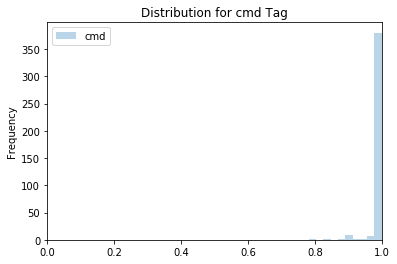

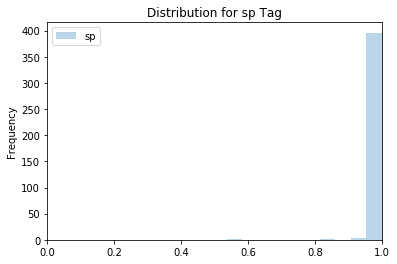

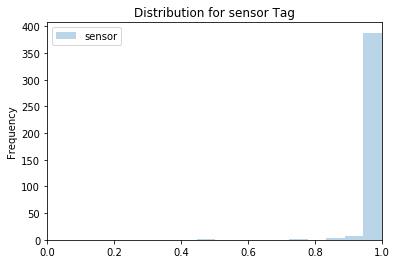

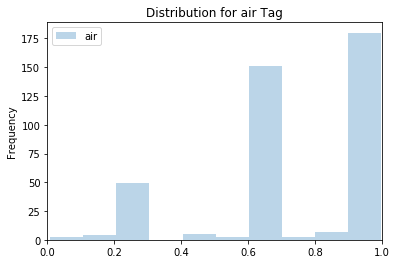

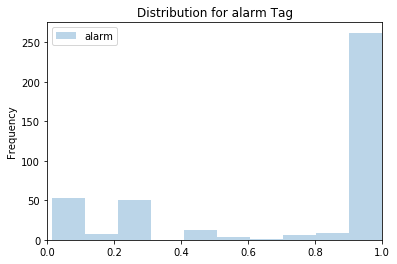

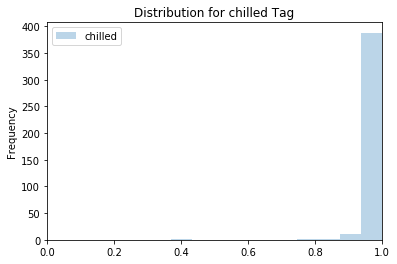

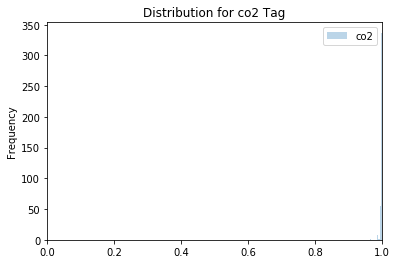

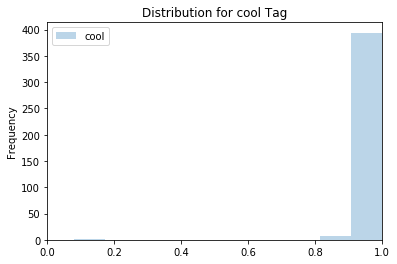

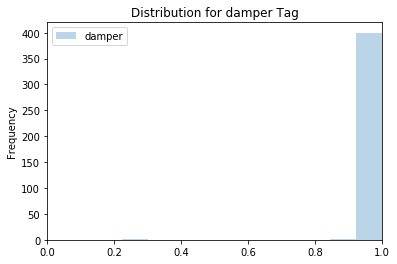

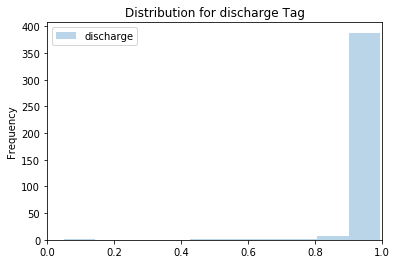

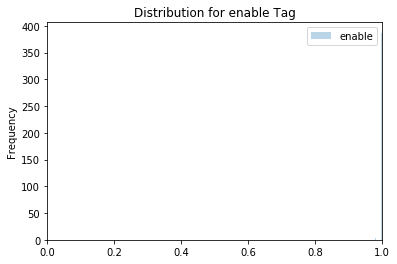

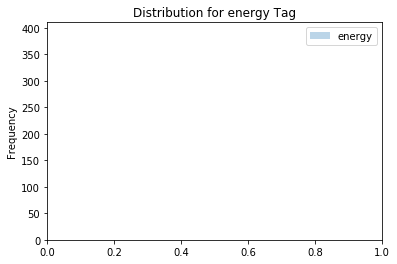

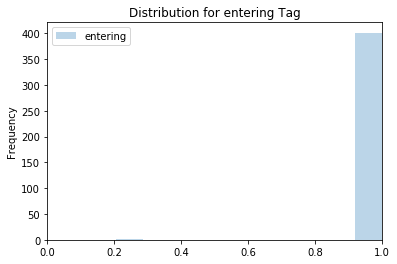

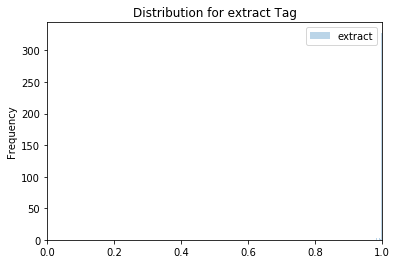

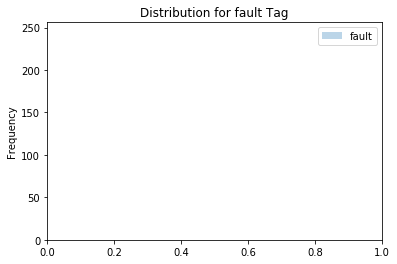

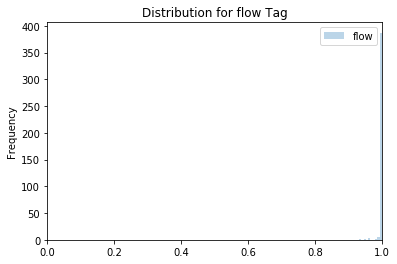

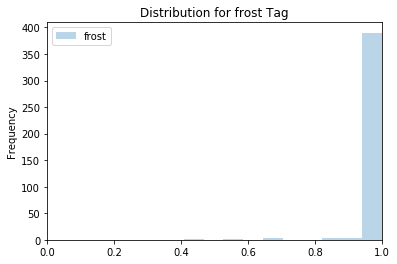

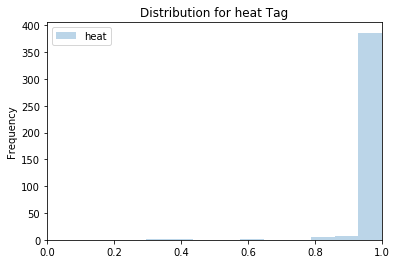

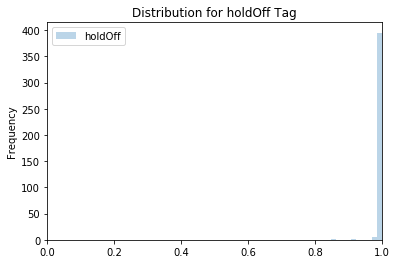

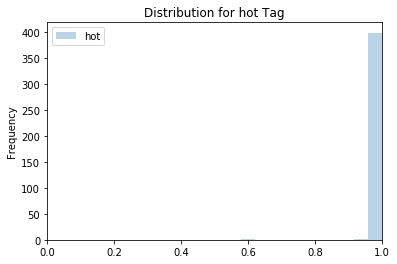

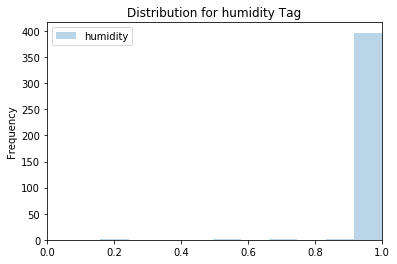

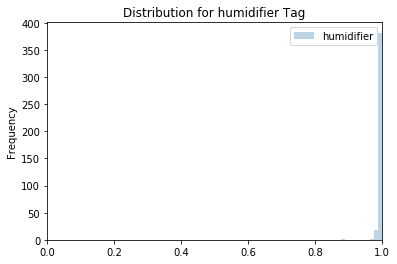

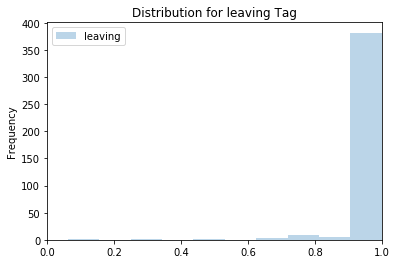

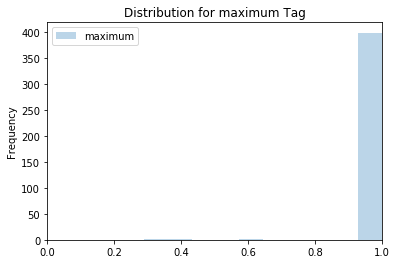

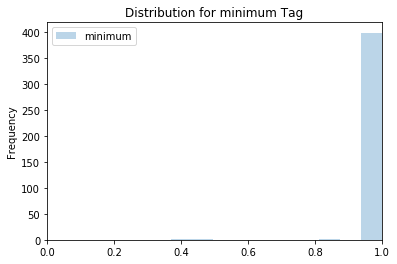

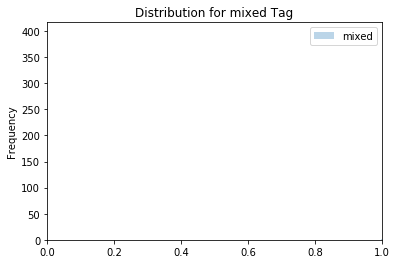

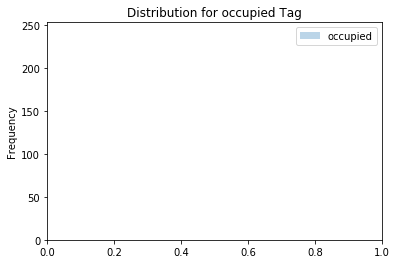

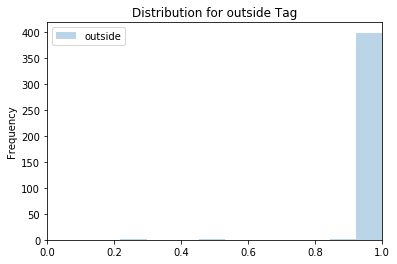

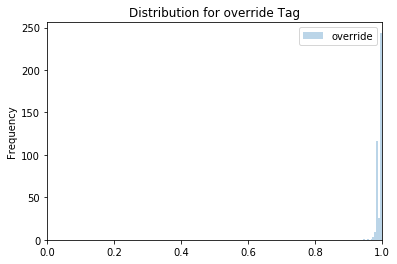

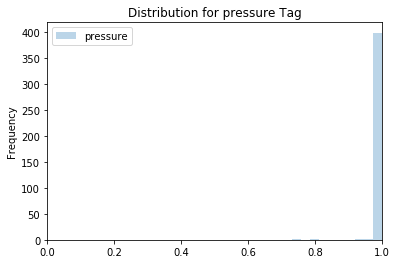

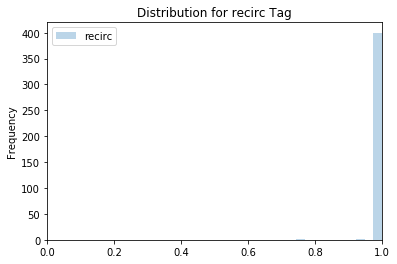

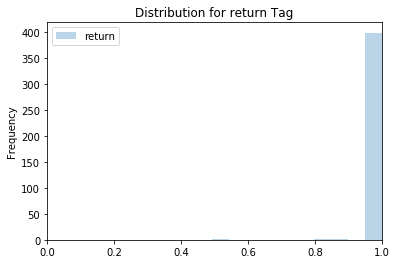

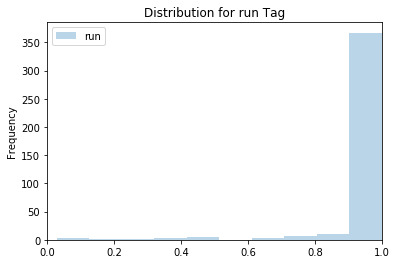

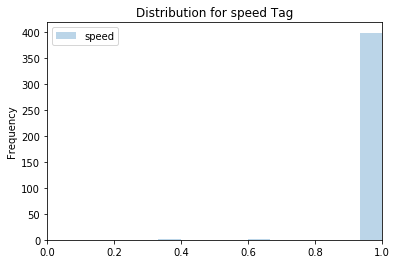

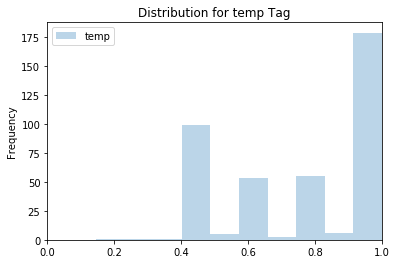

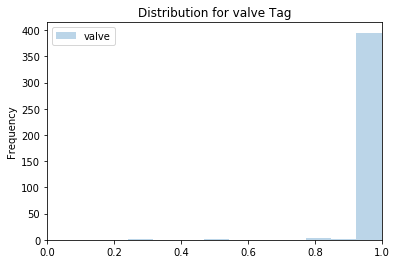

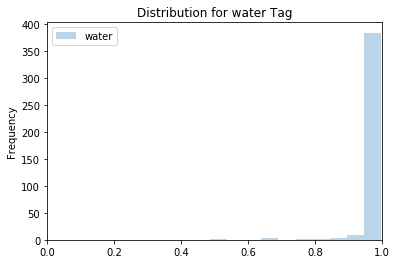

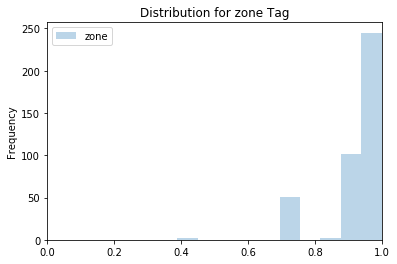

In [127]:
for category in list(confi_df):
    hist = confi_df[[category]].plot.hist(bins=10, alpha=0.3, title = "Distribution for " + category  + " Tag", xlim = (0,1))